In [92]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy 
import keras
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import TfidfVectorizer


In [22]:
train_data=pd.read_csv("train.csv")

In [23]:
test_data=pd.read_csv("test.csv")

In [24]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [25]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [26]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [27]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
comments = train_data.drop(['id','comment_text'],axis = 1)
for i in comments.columns :
    print("Percent of {0}s: ".format(i), round(100*comments[i].mean(),2), "%")

Percent of toxics:  9.58 %
Percent of severe_toxics:  1.0 %
Percent of obscenes:  5.29 %
Percent of threats:  0.3 %
Percent of insults:  4.94 %
Percent of identity_hates:  0.88 %


In [29]:
classes = {}
for i in list(comments.columns):
    classes[i] =  comments[i].sum()
n_classes = [classes[i] for i in list(classes.keys())]
classes = list(classes.keys())

In [30]:
print(classes)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [31]:
color = ['red','blue','green','yellow','black','orange']
plt.figure(figsize=(12,12))
fig, ax = plt.subplots()
ax.bar(classes,n_classes,color = color)

<BarContainer object of 6 artists>

In [32]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    
    return text

In [33]:
clean_text('How are youjhgjhgjgjh&^%&^%&%&%1245 57647474774 YTIIIIUTIkjhkjhHkkkkHHHHHHH')

'how are ytiiiiutikjhkjhhkkkkhhhhhhh'

In [34]:
train_data.comment_text = train_data.comment_text.apply(clean_text)

In [36]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour i am se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cannot make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
5,00025465d4725e87,congratulations from me as well use the tool...,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [40]:
nltk.download('stopwords')
sn = SnowballStemmer(language='english')


def stemmer(text):
    words =  text.split()
    train = [sn.stem(word) for word in words if not word in set(stopwords.words('english'))]
    return ' '.join(train)

In [ ]:
train_data.comment_text = train_data.comment_text.apply(stemmer)


In [82]:
train_data.comment_text.head()

0    explanation why the edits made under my userna...
1    daww he matches this background colour i am se...
2    hey man i am really not trying to edit war it ...
3     more i cannot make any real suggestions on im...
4    you sir are my hero any chance you remember wh...
Name: comment_text, dtype: object

In [90]:
color = ['red','blue','green','yellow','black','orange']
plt.figure(figsize=(12,12))
fig, ax = plt.subplots()
ax.bar(classes,n_classes,color = color)

<BarContainer object of 6 artists>

<Figure size 1200x1200 with 0 Axes>

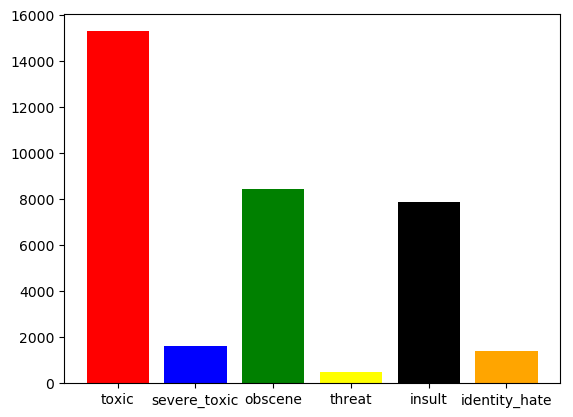

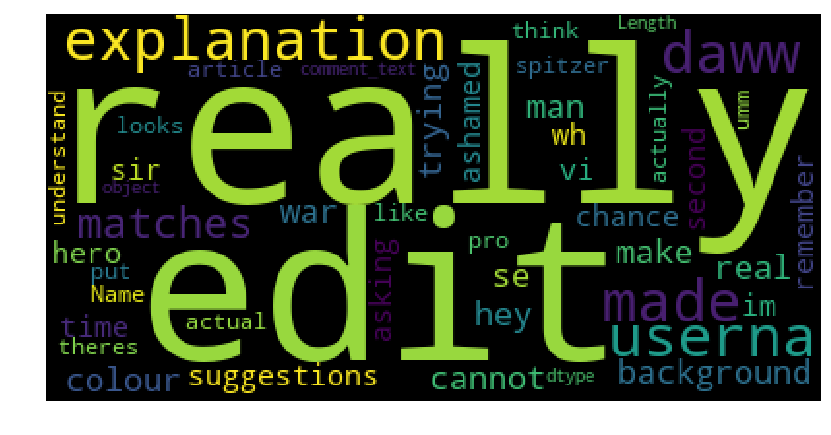

In [91]:
wordcloud = WordCloud(stopwords=stopwords.words('english'),max_words=50).generate(str(train_data.comment_text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [45]:
x =  train_data.comment_text
y =  train_data.drop(['id','comment_text'],axis = 1)

In [46]:
print(type(x))

<class 'pandas.core.series.Series'>


In [47]:
print(type(y))

<class 'pandas.core.frame.DataFrame'>


In [48]:
x_train,x_test,y_train,y_test =  train_test_split(x,y,test_size = 0.2,random_state = 45)

In [49]:
x_train

9162      antecedents etc   it is more a technical manua...
87716                       redirect talkrepublic survivors
63837     possible images   hi patrick take a look here ...
148939       happy new year dheyward   classplainlinks  ...
30008     nobody said that but you have a coi and you ar...
                                ...                        
81853                           this is a message to myself
143967       the attack   i did not attack that is its n...
60960     you should have just banned me on the spot why...
137084     the preceding unsigned comment was added by  ...
137630    dear yamla  once again i am sorry for any misu...
Name: comment_text, Length: 127656, dtype: object

In [50]:
x_train2 = x_train.to_numpy()
x_test2 =  x_test.to_numpy()
y_train2 =  y_train.to_numpy()
y_test =  y_test.to_numpy()

In [51]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',            
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),         
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(x_train2)    
train_word_features = word_vectorizer.transform(x_train2)

In [52]:
import joblib
 
joblib.dump(word_vectorizer, open('vectroize2_jlib', 'wb'))

vectorizer = joblib.load('vectroize2_jlib')

In [53]:
X_train_transformed = vectorizer.transform(x_train2)
X_test_transformed = vectorizer.transform(x_test2)

In [54]:
print(X_train_transformed)

  (0, 4955678)	0.16339505921247377
  (0, 4955677)	0.16339505921247377
  (0, 4954898)	0.06003441001890886
  (0, 4711132)	0.04819014284182887
  (0, 4590091)	0.16339505921247377
  (0, 4590089)	0.1509847528559128
  (0, 4589804)	0.09407658972063271
  (0, 4505797)	0.16339505921247377
  (0, 4505796)	0.16339505921247377
  (0, 4505400)	0.08902454441876456
  (0, 3979253)	0.16339505921247377
  (0, 3979252)	0.16339505921247377
  (0, 3979245)	0.13912734247489664
  (0, 3562522)	0.16339505921247377
  (0, 3562521)	0.16339505921247377
  (0, 3561482)	0.06202243798097669
  (0, 3253119)	0.16339505921247377
  (0, 3253118)	0.16339505921247377
  (0, 3244758)	0.03739689476112349
  (0, 2789318)	0.16339505921247377
  (0, 2789317)	0.16339505921247377
  (0, 2789200)	0.07914294681617362
  (0, 2452121)	0.16339505921247377
  (0, 2452120)	0.16339505921247377
  (0, 2452119)	0.16339505921247377
  :	:
  (127655, 2929230)	0.10221275811995403
  (127655, 2881731)	0.15644181819247763
  (127655, 2567224)	0.15644181819247763


In [55]:
print(X_test_transformed)

  (0, 2959983)	0.2986732653984022
  (0, 2470279)	0.2737158800533047
  (0, 1896826)	0.2886881316819346
  (0, 1811869)	0.3571871840388047
  (0, 1811605)	0.17208523501973905
  (0, 1749971)	0.34094606398964494
  (0, 1749896)	0.26026748692957824
  (0, 1393648)	0.3729096608311308
  (0, 1111631)	0.21298310775534773
  (0, 667883)	0.17485797809356976
  (0, 538551)	0.3616540521456643
  (0, 537875)	0.15499057783733292
  (0, 348997)	0.20381167735887978
  (1, 5291427)	0.07215446447830051
  (1, 5028432)	0.26619177239866537
  (1, 5028201)	0.1938301533618662
  (1, 4881118)	0.16119475151615617
  (1, 4879949)	0.08315493366232785
  (1, 4870296)	0.08355189059205476
  (1, 4425631)	0.09770749499313397
  (1, 4408482)	0.13989596786236191
  (1, 4385502)	0.16119475151615617
  (1, 4384845)	0.14940508364318977
  (1, 4252015)	0.11401571342367342
  (1, 4193255)	0.13496444335889154
  :	:
  (31912, 1168619)	0.14733394007266087
  (31912, 1126289)	0.05332935873719025
  (31912, 1084850)	0.1170541014152053
  (31912, 1005

In [ ]:
log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=45)

classifier = OneVsRestClassifier(log_reg)
classifier.fit(X_train_transformed, y_train)


y_train_pred_proba = classifier.predict_proba(X_train_transformed)
y_test_pred_proba = classifier.predict_proba(X_test_transformed)


roc_auc_score_train = roc_auc_score(y_train2, y_train_pred_proba,average='weighted')
roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba,average='weighted')

print("ROC AUC Score Train:", roc_auc_score_train)
print("ROC AUC Score Test:", roc_auc_score_test)

In [57]:
joblib.dump(classifier, open('classifier2_jlib', 'wb'))

word_vectorizer = joblib.load('classifier2_jlib')

In [58]:
def make_test_predictions(df,classifier):
    df.comment_text = df.comment_text.apply(clean_text)
    df.comment_text = df.comment_text.apply(stemmer)
    X_test = df.comment_text
    X_test =  X_test.to_numpy()
    X_test_transformed = vectorizer.transform(X_test)
    y_test_pred = classifier.predict_proba(X_test_transformed)
    result =  sum(y_test_pred[0])
    if result >=1 :
       return("Offensive Comment")
    else :
       return ("Normal Comment")

In [ ]:
comment_text = "he is nice person"
comment ={'id':[565],'comment_text':[comment_text]}
comment = pd.DataFrame(comment)
result = make_test_predictions(comment,classifier)
print(result)

In [78]:
comment_text = "that son of bitch screwed my promotion"
comment ={'comment_text':[comment_text]}
comment = pd.DataFrame(comment)
result = make_test_predictions(comment,classifier)
print(result)

Offensive Comment
